In [16]:
# ============================================================
# CELL 1 — Install Dependencies
# ============================================================
!apt-get update -y && apt-get install -y cmake libopenmpi-dev python3-dev zlib1g-dev swig
!pip install stable-baselines3[extra]
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip install websockets>=15.0.0 --quiet


# ============================================================
# CELL 2 — All Imports
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pkg_resources

import torch as th
import torch.nn as nn

import stable_baselines3
import finrl

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.config import INDICATORS

%matplotlib inline
plt.close('all')

print(f"SB3 Version:    {stable_baselines3.__version__}")
print(f"FinRL Version:  {pkg_resources.get_distribution('finrl').version}")
print(f"CUDA Available: {th.cuda.is_available()}")

# ── Mac GPU (Metal / MPS) detection ──────────────────────────────────────────
if th.backends.mps.is_available():
    DEVICE = th.device('mps')
    print("MPS (Apple Metal GPU) available — using GPU ✓")
elif th.cuda.is_available():
    DEVICE = th.device('cuda')
    print(f"CUDA GPU available — using {th.cuda.get_device_name(0)} ✓")
else:
    DEVICE = th.device('cpu')
    print("No GPU found — falling back to CPU")

print(f"Active device: {DEVICE}")


# ============================================================
# CELL 3 — Download Data
# ============================================================
TICKERS = [
    'NVDA', 'AAPL', 'GOOGL', 'GOOG', 'MSFT', 'AMZN', 'META', 'AVGO', 'TSLA',
    'WMT', 'LLY', 'JPM', 'XOM', 'V', 'JNJ', 'MU','MA', 'COST', 'ORCL',
    'ABBV',  'BAC', 'HD', 'PG', 'CVX', 'GE', 'CAT',  'KO', 'NFLX', 'AMD','CSCO'
]
NUM_STOCKS = len(TICKERS)  # 30 — use this constant everywhere, no magic numbers

# Download training data
df_raw_train = YahooDownloader(
    start_date='2020-01-01',
    end_date='2024-01-01',
    ticker_list=TICKERS
).fetch_data()

# Download test data (held-out period)
df_raw_test = YahooDownloader(
    start_date='2024-01-01',
    end_date='2025-01-01',
    ticker_list=TICKERS
).fetch_data()

# Add Technical Indicators
fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list=INDICATORS,
    use_vix=False,
    use_turbulence=False
)

df_train = fe.preprocess_data(df_raw_train)
df_test  = fe.preprocess_data(df_raw_test)

print(f"Train shape: {df_train.shape}")
print(f"Test shape:  {df_test.shape}")


# ============================================================
# CELL 4 — Clean & Validate Data
# ============================================================
def prepare_df(df, n_stocks=NUM_STOCKS):
    """Sort, validate ticker completeness, and set a numeric date index."""
    df = df.rename(columns={'datadate': 'date'})  # no-op if column doesn't exist
    df = df.sort_values(['date', 'tic']).reset_index(drop=True)

    # Drop dates that don't have all tickers (prevents float-state bugs)
    ticker_counts = df.groupby('date')['tic'].nunique()
    incomplete = ticker_counts[ticker_counts != n_stocks].index
    if len(incomplete) > 0:
        print(f"Dropping {len(incomplete)} incomplete date(s): {list(incomplete[:5])}{'...' if len(incomplete) > 5 else ''}")
        df = df[~df['date'].isin(incomplete)].reset_index(drop=True)

    # StockTradingEnv uses df.loc[self.day, :] — must be a numeric index
    df.index = df['date'].factorize()[0]
    return df

df_train = prepare_df(df_train)
df_test  = prepare_df(df_test)

print(f"Train ready — {df_train['date'].nunique()} trading days")
print(f"Test  ready — {df_test['date'].nunique()} trading days")


# ============================================================
# CELL 5 — Define Model & Train
# ============================================================
INDICATORS_COUNT     = len(INDICATORS)                        # typically 8
INDICATORS_START_IDX = 1 + NUM_STOCKS + NUM_STOCKS           # skip: Cash + Prices + Shares
STATE_SPACE          = INDICATORS_START_IDX + (NUM_STOCKS * INDICATORS_COUNT)

class VGG_FinRL_Extractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=512, n_stocks=NUM_STOCKS, n_ind=INDICATORS_COUNT):
        super().__init__(observation_space, features_dim)
        self.n_stocks = n_stocks
        self.n_ind    = n_ind

        self.input_norm = nn.BatchNorm2d(1)

        self.vgg = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
        )

        # Probe passes through input_norm to stay consistent with forward()
        with th.no_grad():
            # Use CPU for the probe — MPS doesn't support BatchNorm in inference mode
            sample    = th.zeros(1, 1, n_stocks, n_ind)
            _norm_cpu = nn.BatchNorm2d(1)
            _vgg_cpu  = nn.Sequential(
                nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            )
            sample    = _norm_cpu(sample)
            n_flatten = _vgg_cpu(sample).numel()

        # Dropout removed — it destabilises the RL critic's value estimates
        self.fc = nn.Sequential(
            nn.Linear(n_flatten, features_dim),
            nn.ReLU()
        )

    def forward(self, observations):
        img_data = observations[:, INDICATORS_START_IDX:]
        img_data = img_data.view(-1, 1, self.n_stocks, self.n_ind)
        img_data = self.input_norm(img_data)
        x = self.vgg(img_data)
        x = th.flatten(x, start_dim=1)
        return self.fc(x)

policy_kwargs = dict(
    features_extractor_class=VGG_FinRL_Extractor,
    features_extractor_kwargs=dict(
        features_dim=512,
        n_stocks=NUM_STOCKS,
        n_ind=INDICATORS_COUNT
    ),
)

def make_env(df):
    return StockTradingEnv(
        df=df,
        num_stock_shares=[0] * NUM_STOCKS,
        reward_scaling=1e-4,
        stock_dim=NUM_STOCKS,
        hmax=100,
        initial_amount=1_000_000,
        buy_cost_pct=[0.001]  * NUM_STOCKS,
        sell_cost_pct=[0.001] * NUM_STOCKS,
        state_space=STATE_SPACE,
        tech_indicator_list=INDICATORS,
        action_space=NUM_STOCKS
    )

e_train_gym = make_env(df_train)
e_test_gym  = make_env(df_test)

env_train, _ = e_train_gym.get_sb_env()

model_params = {
    "n_steps":       2048,
    "ent_coef":      0.01,
    "learning_rate": 0.0001,
    "batch_size":    64,
    "device":        DEVICE,   # <-- uses MPS on Mac, CUDA if available, else CPU
}

agent     = DRLAgent(env=env_train)
model_vgg = agent.get_model(
    "ppo",
    policy_kwargs=policy_kwargs,
    model_kwargs=model_params,
    verbose=1
)

print("Starting VGG Training...")
# Increased timesteps — 100k is too few for 30 stocks; start at 500k
trained_vgg = agent.train_model(
    model=model_vgg,
    tb_log_name='vgg_ppo_run',
    total_timesteps=500_000
)


# ============================================================
# CELL 6 — Sanity Check Training Behaviour
# ============================================================
shares_start = 1 + NUM_STOCKS   # skip Cash + Prices
shares_end   = shares_start + NUM_STOCKS

final_shares = np.array(e_train_gym.state_memory)[-1][shares_start:shares_end]
print(f"Total shares held across all stocks: {np.sum(final_shares)}")

actions = np.array(e_train_gym.actions_memory)
print(f"Average absolute action strength: {np.mean(np.abs(actions)):.6f}")

def compute_metrics(df_account_value: pd.DataFrame,
                    initial_capital: float = 1_000_000) -> dict:
    """
    Compute key trading performance metrics from account value history.

    Metrics:
      - Total Return:       overall % gain/loss
      - Sharpe Ratio:       risk-adjusted return (annualised)
      - Max Drawdown:       largest peak-to-trough decline (%)
      - Win Rate:           % of days with positive return
      - Avg Daily Return:   mean daily % return
      - Volatility:         annualised std of daily returns
      - Calmar Ratio:       total return / max drawdown
    """
    values  = pd.Series(df_account_value['account_value'].values,
                        index=pd.to_datetime(df_account_value['date'].values))

    # Daily returns
    daily_returns = values.pct_change().dropna()

    # Total return
    total_return = (values.iloc[-1] - initial_capital) / initial_capital * 100

    # Sharpe ratio (annualised, assuming 252 trading days)
    sharpe = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252) \
             if daily_returns.std() > 0 else 0.0

    # Maximum drawdown
    rolling_max  = values.cummax()
    drawdown     = (values - rolling_max) / rolling_max * 100
    max_drawdown = drawdown.min()   # most negative value = worst drawdown

    # Win rate — % of days with positive return
    win_rate = (daily_returns > 0).sum() / len(daily_returns) * 100

    # Average daily return
    avg_daily_return = daily_returns.mean() * 100

    # Annualised volatility
    volatility = daily_returns.std() * np.sqrt(252) * 100

    # Calmar ratio (total return / abs max drawdown)
    calmar = abs(total_return / max_drawdown) if max_drawdown != 0 else 0.0

    return {
        'Total Return (%)':     round(total_return, 2),
        'Sharpe Ratio':         round(sharpe, 3),
        'Max Drawdown (%)':     round(max_drawdown, 2),
        'Win Rate (%)':         round(win_rate, 2),
        'Avg Daily Return (%)': round(avg_daily_return, 4),
        'Volatility (%)':       round(volatility, 2),
        'Calmar Ratio':         round(calmar, 3),
    }


# Compute and print metrics for training environment
# We need to run a quick prediction pass on the training env
# to get a clean account value history
df_train_account, _ = DRLAgent.DRL_prediction(
    model=trained_vgg,
    environment=e_train_gym
)


zsh:1: command not found: apt-get
zsh:1: no matches found: stable-baselines3[extra]
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /private/var/folders/sc/40gcq14x2cng8czg1s_vpkbr0000gn/T/pip-req-build-jj4uitag
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /private/var/folders/sc/40gcq14x2cng8czg1s_vpkbr0000gn/T/pip-req-build-jj4uitag
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit f4283de63ca73c915321c5555fa3751698a61eec
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /private/var/folders/sc/40gcq14x2cng8czg1s_vpkbr0000gn/T/pip-install-g8e79pe7/elegantrl_bbda75e441524a39a41b22b1c640bf27
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /private/var/folders/sc/40gcq14x2cng8cz

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

SB3 Version:    2.8.0a2
FinRL Version:  0.3.8
CUDA Available: False
MPS (Apple Metal GPU) available — using GPU ✓
Active device: mps



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

Shape of DataFrame:  (30180, 8)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

Shape of DataFrame:  (7560, 8)
Successfully added technical indicators
Successfully added technical indicators
Train shape: (30180, 16)
Test shape:  (7560, 16)
Train ready — 1006 trading days
Test  ready — 252 trading days
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.0001, 'batch_size': 64, 'device': device(type='mps')}
Using mps device


/opt/miniconda3/lib/python3.13/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning:

You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.



Starting VGG Training...
------------------------------------
| time/              |             |
|    fps             | 234         |
|    iterations      | 1           |
|    time_elapsed    | 8           |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | -2.625811   |
|    reward_max      | 7.414955    |
|    reward_mean     | 0.0488092   |
|    reward_min      | -10.0611105 |
------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 181        |
|    iterations           | 2          |
|    time_elapsed         | 22         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00974913 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -42.6      |
|    explained_variance   | -0.0161    |
|    learning_rate        | 0.0001     

Computing training metrics...


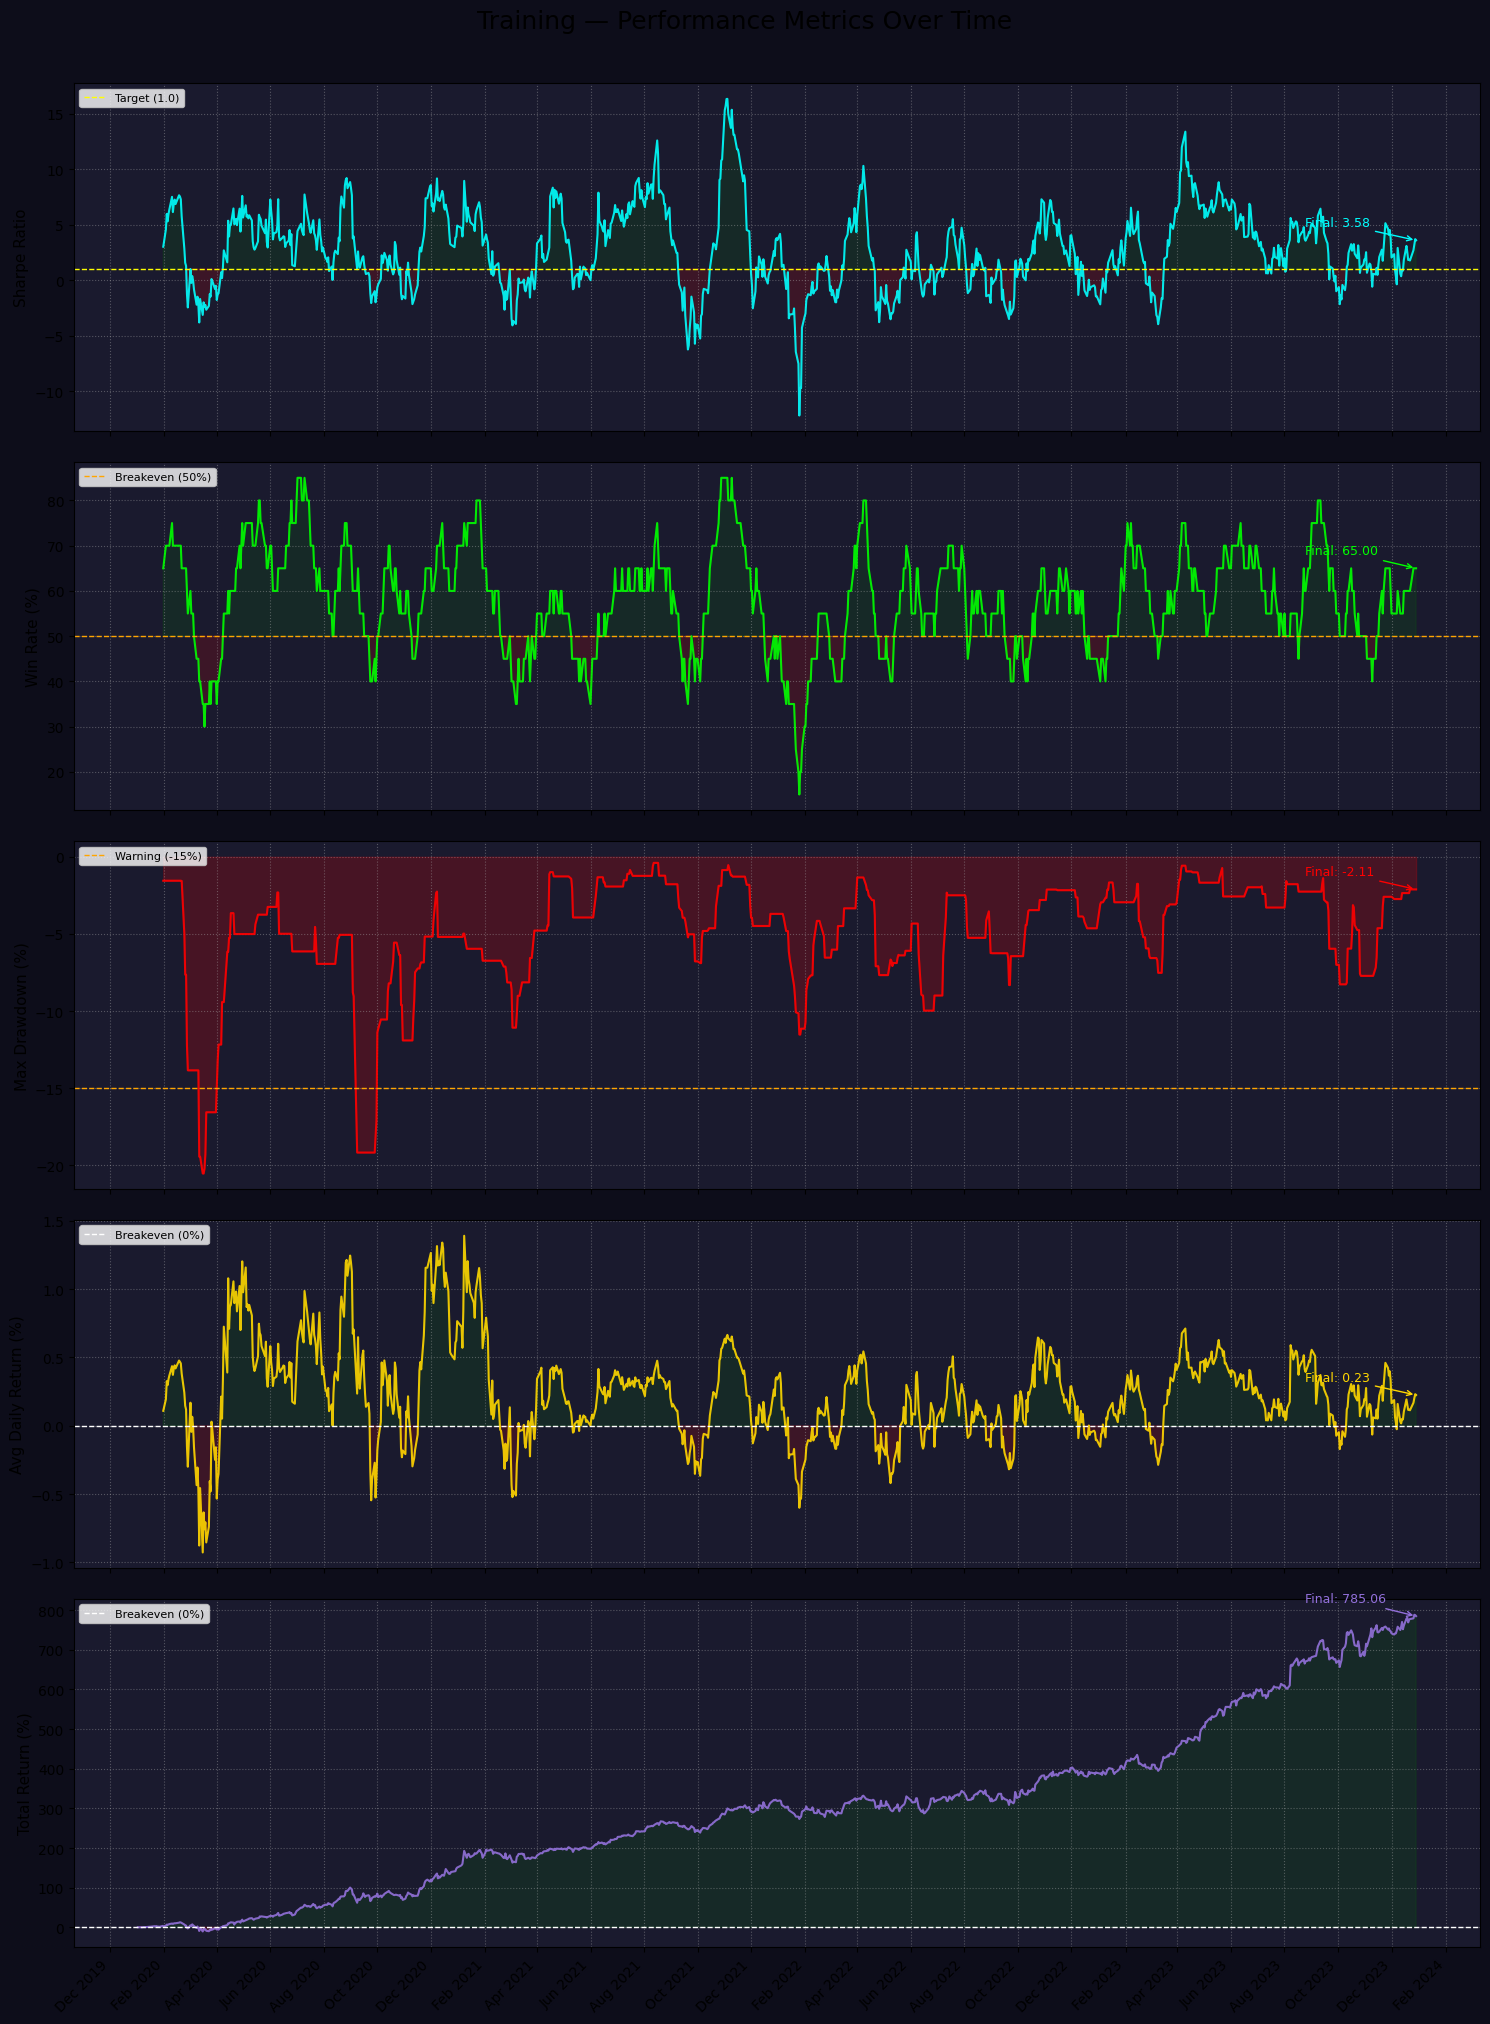


  TRAINING — FINAL METRIC VALUES
  Sharpe Ratio                   3.580
  Win Rate (%)                  65.000
  Max Drawdown (%)              -2.112
  Avg Daily Return (%)           0.225
  Total Return (%)             785.058
Computing test metrics...


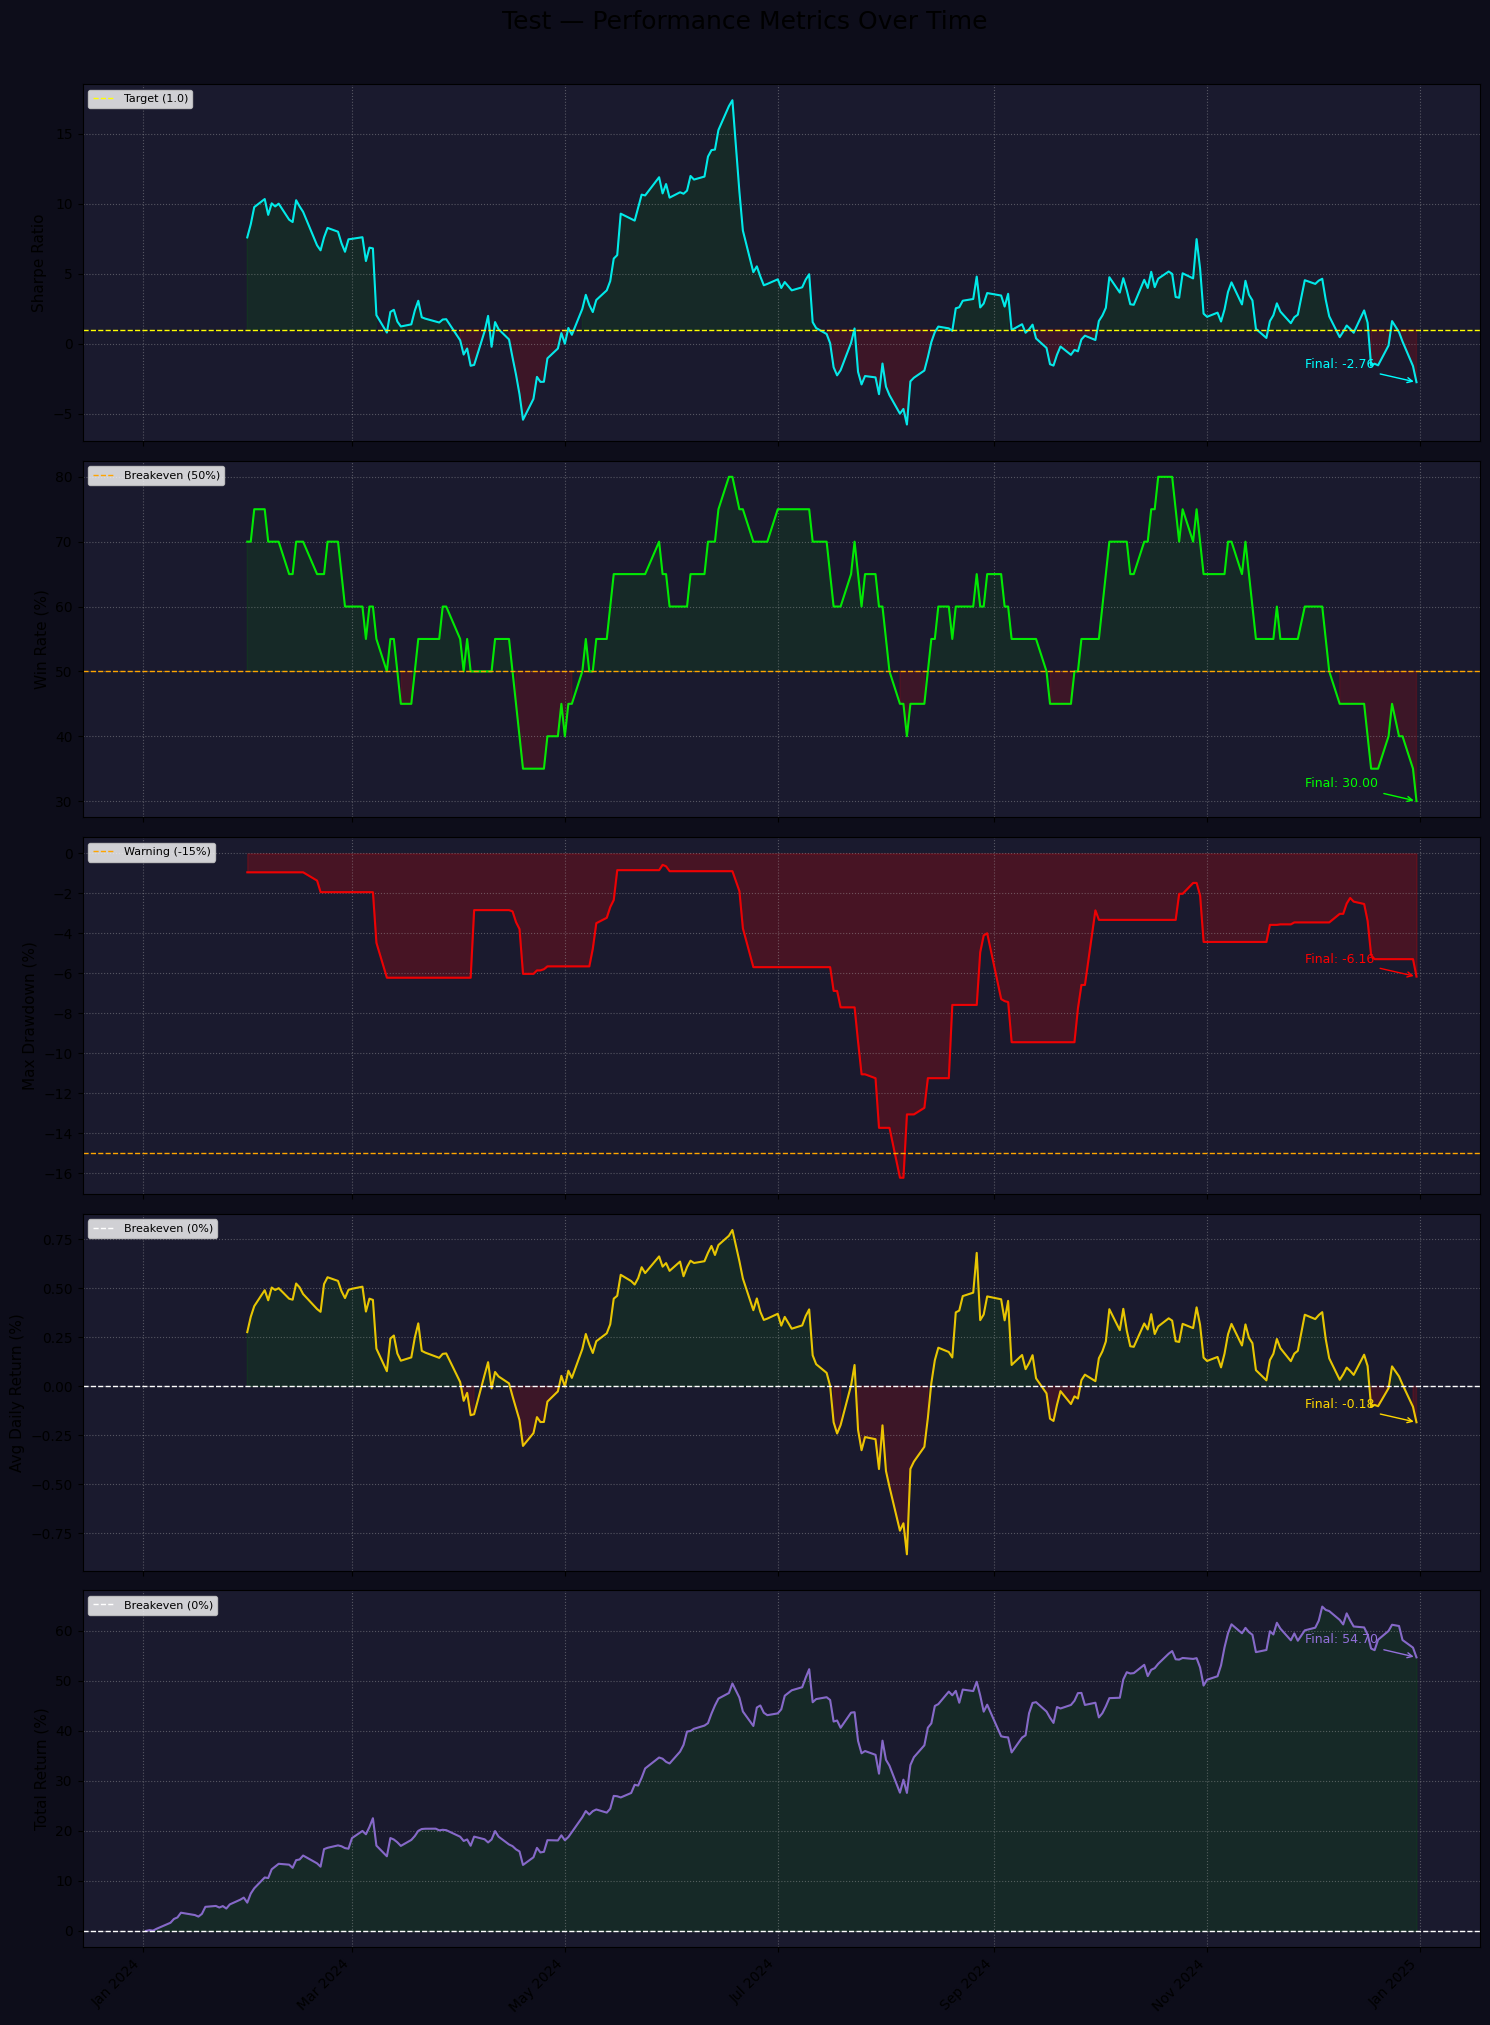


  TEST — FINAL METRIC VALUES
  Sharpe Ratio                  -2.761
  Win Rate (%)                  30.000
  Max Drawdown (%)              -6.158
  Avg Daily Return (%)          -0.183
  Total Return (%)              54.700


In [17]:
# ============================================================
# CELL 6b — Plot Metrics Over Time
# ============================================================

def compute_rolling_metrics(df_account_value: pd.DataFrame,
                             initial_capital: float = 1_000_000,
                             window: int = 20) -> pd.DataFrame:
    """
    Compute rolling metrics over time so we can plot how each
    metric evolves over the course of the model's trading history.

    window: rolling window in trading days (default 20 = 1 month)
    """
    values = pd.Series(
        df_account_value['account_value'].values,
        index=pd.to_datetime(df_account_value['date'].values)
    )

    daily_returns = values.pct_change().dropna()

    # Rolling Sharpe (annualised)
    rolling_sharpe = (
        daily_returns.rolling(window).mean() /
        daily_returns.rolling(window).std()
    ) * np.sqrt(252)

    # Rolling Win Rate
    rolling_win_rate = (
        daily_returns.rolling(window)
        .apply(lambda x: (x > 0).sum() / len(x) * 100)
    )

    # Rolling Max Drawdown
    def rolling_max_drawdown(returns):
        cum    = (1 + returns).cumprod()
        peak   = cum.cummax()
        dd     = (cum - peak) / peak * 100
        return dd.min()

    rolling_max_dd = (
        daily_returns.rolling(window)
        .apply(rolling_max_drawdown)
    )

    # Rolling Avg Daily Return
    rolling_avg_return = daily_returns.rolling(window).mean() * 100

    # Cumulative Total Return over time
    total_return = (values - initial_capital) / initial_capital * 100

    metrics_df = pd.DataFrame({
        'Sharpe Ratio':         rolling_sharpe,
        'Win Rate (%)':         rolling_win_rate,
        'Max Drawdown (%)':     rolling_max_dd,
        'Avg Daily Return (%)': rolling_avg_return,
        'Total Return (%)':     total_return,
    })

    return metrics_df


def plot_metrics(metrics_df: pd.DataFrame, title_prefix: str = 'Training'):
    """
    Plot all five metrics in a clean multi-panel figure.
    Each metric gets its own subplot with appropriate colouring.
    """
    fig, axes = plt.subplots(5, 1, figsize=(15, 20), sharex=True)
    fig.suptitle(f'{title_prefix} — Performance Metrics Over Time',
                 fontsize=18, y=1.01)

    plot_config = [
        {
            'col':    'Sharpe Ratio',
            'color':  'cyan',
            'ylabel': 'Sharpe Ratio',
            'hline':  1.0,
            'hline_label': 'Target (1.0)',
            'hline_color': 'yellow',
        },
        {
            'col':    'Win Rate (%)',
            'color':  'lime',
            'ylabel': 'Win Rate (%)',
            'hline':  50.0,
            'hline_label': 'Breakeven (50%)',
            'hline_color': 'orange',
        },
        {
            'col':    'Max Drawdown (%)',
            'color':  'red',
            'ylabel': 'Max Drawdown (%)',
            'hline':  -15.0,
            'hline_label': 'Warning (-15%)',
            'hline_color': 'orange',
        },
        {
            'col':    'Avg Daily Return (%)',
            'color':  'gold',
            'ylabel': 'Avg Daily Return (%)',
            'hline':  0.0,
            'hline_label': 'Breakeven (0%)',
            'hline_color': 'white',
        },
        {
            'col':    'Total Return (%)',
            'color':  'mediumpurple',
            'ylabel': 'Total Return (%)',
            'hline':  0.0,
            'hline_label': 'Breakeven (0%)',
            'hline_color': 'white',
        },
    ]

    for ax, cfg in zip(axes, plot_config):
        series = metrics_df[cfg['col']].dropna()

        ax.plot(series.index, series.values,
                color=cfg['color'], linewidth=1.5, alpha=0.9)

        # Fill above/below reference line
        ax.axhline(cfg['hline'], color=cfg['hline_color'],
                   linestyle='--', linewidth=1, label=cfg['hline_label'])

        if cfg['col'] == 'Max Drawdown (%)':
            # Always fill red for drawdown
            ax.fill_between(series.index, series.values, 0,
                            alpha=0.2, color='red')
        else:
            ax.fill_between(series.index, series.values, cfg['hline'],
                            where=series.values >= cfg['hline'],
                            alpha=0.15, color='green')
            ax.fill_between(series.index, series.values, cfg['hline'],
                            where=series.values < cfg['hline'],
                            alpha=0.15, color='red')

        ax.set_ylabel(cfg['ylabel'], fontsize=11)
        ax.legend(loc='upper left', fontsize=8)
        ax.grid(True, linestyle=':', alpha=0.4)
        ax.set_facecolor('#1a1a2e')

        # Annotate final value
        final_val = series.iloc[-1] if len(series) > 0 else 0
        ax.annotate(
            f'Final: {final_val:.2f}',
            xy=(series.index[-1], final_val),
            xytext=(-80, 10),
            textcoords='offset points',
            fontsize=9,
            color=cfg['color'],
            arrowprops=dict(arrowstyle='->', color=cfg['color'], lw=1)
        )

        # Format x axis dates
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    plt.setp(axes[-1].get_xticklabels(), rotation=45, ha='right')
    fig.patch.set_facecolor('#0d0d1a')
    fig.tight_layout()
    plt.show()

    # ── Summary table ─────────────────────────────────────────
    final_metrics = metrics_df.iloc[-1]
    print(f"\n{'='*50}")
    print(f"  {title_prefix.upper()} — FINAL METRIC VALUES")
    print(f"{'='*50}")
    for col in metrics_df.columns:
        val = final_metrics[col]
        print(f"  {col:<25} {val:>10.3f}")
    print(f"{'='*50}")


# ── Run for training ──────────────────────────────────────────
print("Computing training metrics...")
train_rolling = compute_rolling_metrics(df_train_account, window=20)
plot_metrics(train_rolling, title_prefix='Training')

# ── Run for test ──────────────────────────────────────────────
print("Computing test metrics...")
test_rolling = compute_rolling_metrics(df_account_value, window=20)
plot_metrics(test_rolling, title_prefix='Test')

hit end!


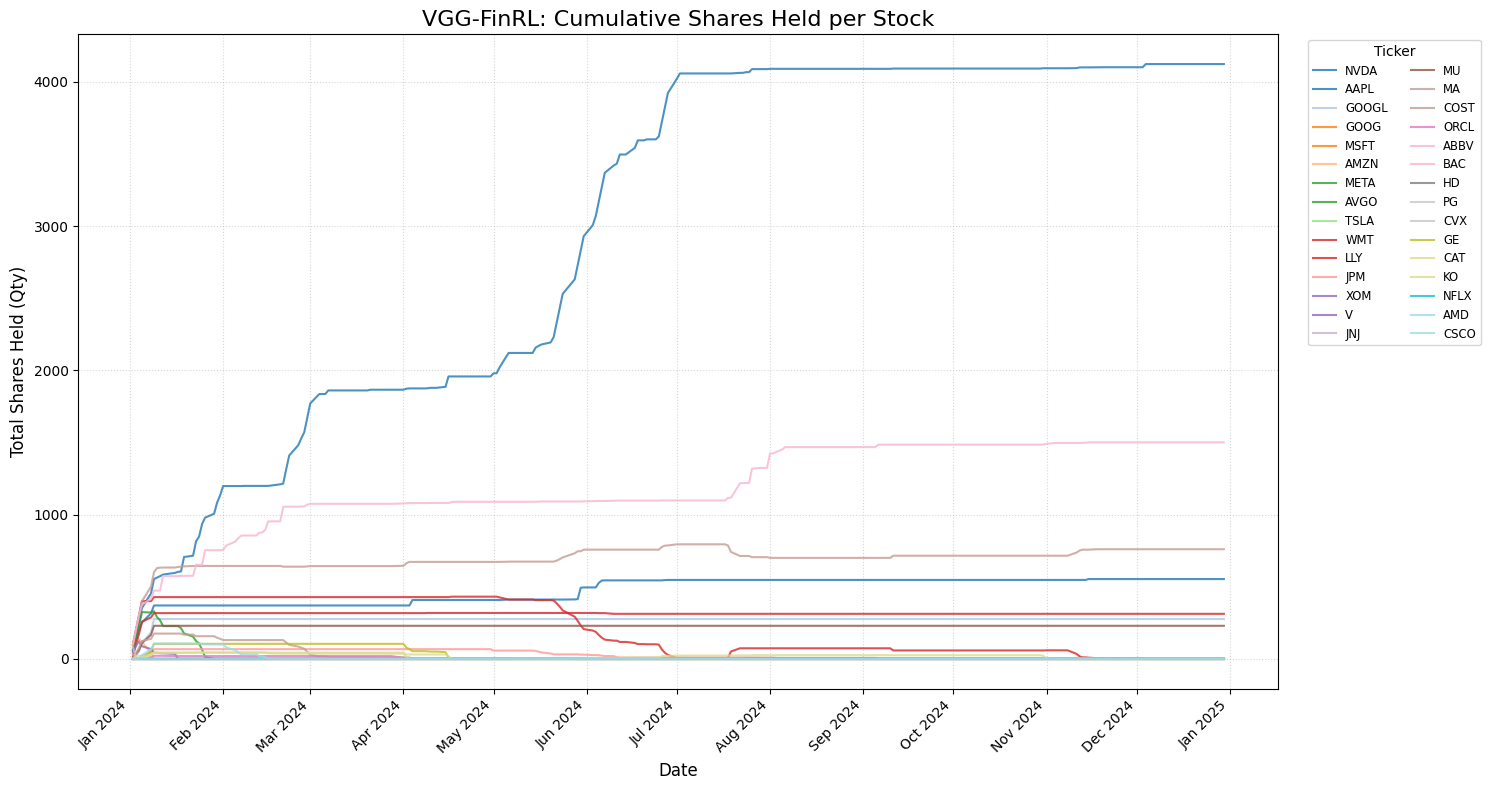

In [ ]:
# ============================================================
# CELL 7 — Run Prediction & Plot Cumulative Shares Held
# ============================================================
import matplotlib.dates as mdates
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_vgg,
    environment=e_test_gym
)

# Parse dates as proper datetime
df_shares_held = df_actions.cumsum()
dates_all      = pd.to_datetime(df_account_value['date'].values)

min_len     = min(len(dates_all), len(df_shares_held))
dates_plot  = dates_all[:min_len]
shares_plot = df_shares_held.iloc[:min_len]

fig, ax = plt.subplots(figsize=(15, 8))
colormap = plt.get_cmap('tab20', len(TICKERS))

for i, ticker in enumerate(TICKERS):
    if ticker in shares_plot.columns:
        ax.plot(dates_plot, shares_plot[ticker], label=ticker,
                color=colormap(i), linewidth=1.5, alpha=0.8)

# Format x-axis as proper dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_title('VGG-FinRL: Cumulative Shares Held per Stock', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Shares Held (Qty)', fontsize=12)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', ncol=2, fontsize='small', title='Ticker')
ax.grid(True, linestyle=':', alpha=0.5)
fig.tight_layout()
plt.show()


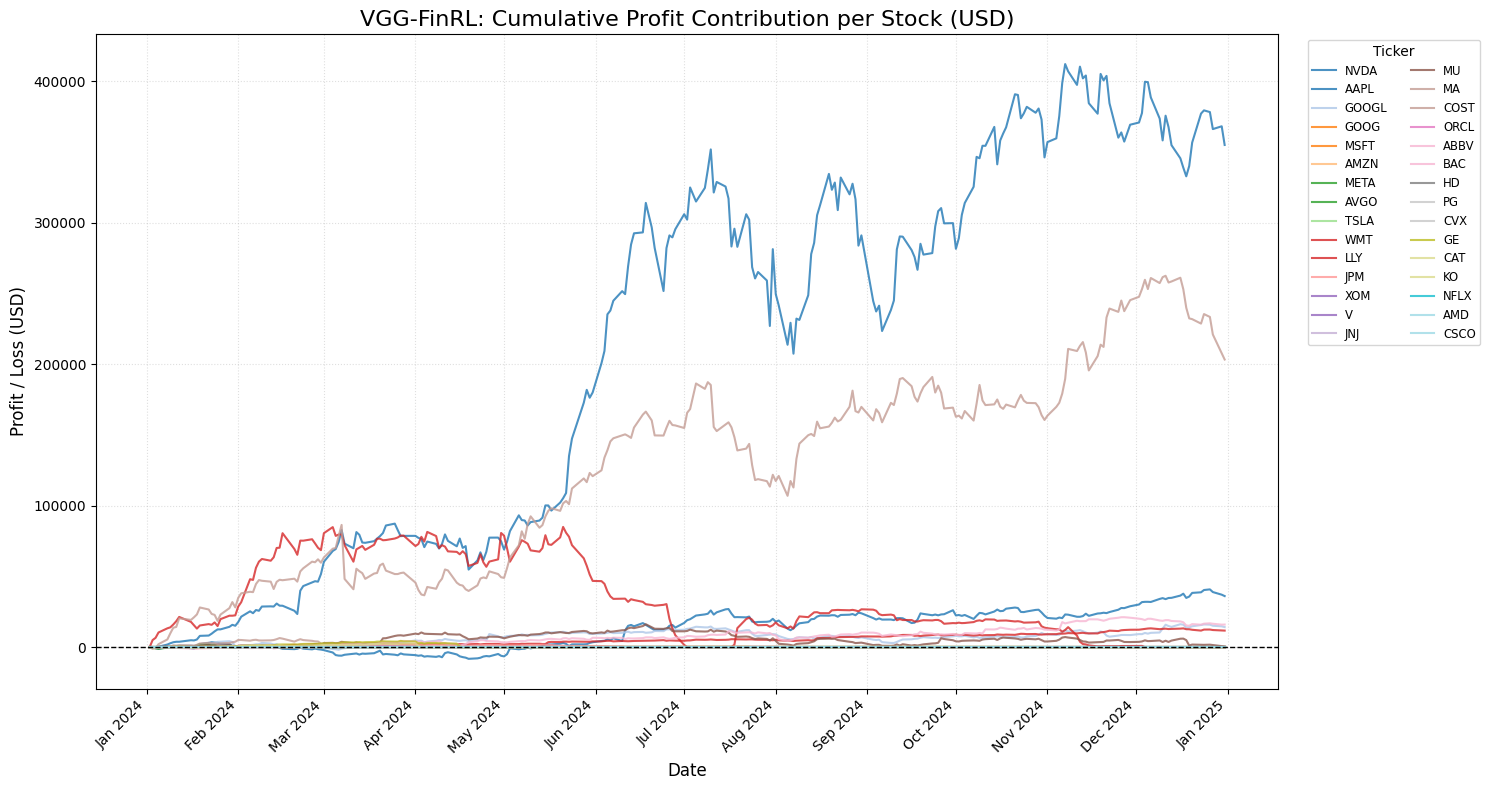

In [ ]:
# ============================================================
# CELL 8 — Plot Profit Contribution per Stock
# ============================================================
# Pivot prices and join on date index so alignment is guaranteed
df_prices_pivot = (
    e_test_gym.df
    .sort_values(['date', 'tic'])
    .pivot(index='date', columns='tic', values='close')
)

df_shares_held = df_actions.cumsum()
df_shares_held.index = dates_all[:len(df_shares_held)]  # align by date (already datetime)

# Cast price index to datetime, then reindex and forward-fill
price_dates           = pd.to_datetime(df_prices_pivot.index)
df_prices_pivot.index = price_dates
df_shares_aligned     = df_shares_held.reindex(price_dates).ffill().fillna(0)

profit_df = pd.DataFrame(index=price_dates)
for ticker in TICKERS:
    if ticker in df_prices_pivot.columns and ticker in df_shares_aligned.columns:
        prices        = df_prices_pivot[ticker]
        initial_price = prices.iloc[0]
        profit_df[ticker] = (prices - initial_price) * df_shares_aligned[ticker]

fig, ax = plt.subplots(figsize=(15, 8))
colormap = plt.get_cmap('tab20', len(TICKERS))

for i, ticker in enumerate(TICKERS):
    if ticker in profit_df.columns:
        ax.plot(profit_df.index, profit_df[ticker], label=ticker,
                color=colormap(i), linewidth=1.5, alpha=0.8)

ax.axhline(0, color='black', lw=1, linestyle='--')

# Format x-axis as proper dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_title('VGG-FinRL: Cumulative Profit Contribution per Stock (USD)', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Profit / Loss (USD)', fontsize=12)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', ncol=2, fontsize='small', title='Ticker')
ax.grid(True, linestyle=':', alpha=0.4)
fig.tight_layout()
plt.show()

In [ ]:
# ============================================================
# CELL 9 — Compute True P&L (Current Holding Value)
# ============================================================
true_pnl_df = (df_prices_pivot * df_shares_aligned).fillna(0)
true_pnl_df = true_pnl_df.reset_index().rename(columns={'date': 'Date'})

In [ ]:
!pip install --upgrade nbformat

In [ ]:
# ============================================================
# CELL 10 — Interactive Plotly P&L Chart
# ============================================================
final_pnl   = true_pnl_df[TICKERS].iloc[-1]
top_5       = final_pnl.nlargest(5).index.tolist()
bottom_5    = final_pnl.nsmallest(5).index.tolist()
key_tickers = set(top_5 + bottom_5)

fig = go.Figure()

for ticker in TICKERS:
    if ticker not in true_pnl_df.columns:
        continue
    fig.add_trace(go.Scatter(
        x=true_pnl_df['Date'],
        y=true_pnl_df[ticker],
        name=ticker,
        mode='lines',
        visible=True if ticker in key_tickers else 'legendonly',
        hovertemplate=f"<b>{ticker}</b><br>PnL: %{{y:$.2f}}<br>Date: %{{x}}<extra></extra>"
    ))

fig.update_layout(
    title='VGG-FinRL: Individual Stock P&L (Hover over lines to see details)',
    template='plotly_dark',
    hovermode='closest',
    hoverlabel=dict(bgcolor='black', font_size=13),
    xaxis_title='Date',
    yaxis_title='Profit / Loss (USD)',
    legend=dict(groupclick='toggleitem', traceorder='grouped')
)
fig.update_xaxes(rangeslider_visible=True)
#fig.write_html("pnl_chart.html")
#print("Open pnl_chart.html in your browser")
fig.show()

In [ ]:
df_train.to_csv('FinRL_train.csv')
df_test.to_csv('FinRL_validation.csv')